<a href="https://colab.research.google.com/github/Ashok401/AIML_BootCamp/blob/main/Copy_of_iPhone_Reviews_Sentiment_and_Feature_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mrmars1010_iphone_customer_reviews_nlp_path = kagglehub.dataset_download('mrmars1010/iphone-customer-reviews-nlp')

print('Data source import complete.')


Data source import complete.


# **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# **Load and Explore the Dataset**

In [3]:
# Load dataset
df = pd.read_csv('iphone.csv')

# Display basic information
print("Dataset information:")
df.info()

# Display first few rows
print("First few rows of the dataset:")
df.head()

# Check for missing values
print("Missing values in the dataset:")
df.isnull().sum()

# Describe numeric columns
print("Summary statistics:")
df.describe()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   productAsin        3062 non-null   object
 1   country            3062 non-null   object
 2   date               3062 non-null   object
 3   isVerified         3062 non-null   bool  
 4   ratingScore        3062 non-null   int64 
 5   reviewTitle        3062 non-null   object
 6   reviewDescription  2976 non-null   object
 7   reviewUrl          3046 non-null   object
 8   reviewedIn         3062 non-null   object
 9   variant            3062 non-null   object
 10  variantAsin        3062 non-null   object
dtypes: bool(1), int64(1), object(9)
memory usage: 242.3+ KB
First few rows of the dataset:
Missing values in the dataset:
Summary statistics:


,ratingScore
count,3062.000000
mean,3.758981
std,1.579033
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


# **Data Cleaning and Preprocessing**

In [4]:
# Display the column names in the dataset
print(df.columns)

Index(['productAsin', 'country', 'date', 'isVerified', 'ratingScore',
       'reviewTitle', 'reviewDescription', 'reviewUrl', 'reviewedIn',
       'variant', 'variantAsin'],
      dtype='object')


In [5]:
# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download punkt_tab resource

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean text
def clean_text(text):
    # Convert text to string to handle any non-string entries
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

# Define a function to preprocess text (tokenization + stopword removal)
def preprocess_text(text):
    words = word_tokenize(text)  # Tokenize text
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply text cleaning and preprocessing
df['cleaned_review'] = df['reviewDescription'].apply(clean_text)
df['processed_review'] = df['cleaned_review'].apply(preprocess_text)

# Display a sample of processed reviews
print("Sample processed reviews:")
print(df[['reviewDescription', 'cleaned_review', 'processed_review']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sample processed reviews:
                                   reviewDescription  \
0  Every thing is good about iPhones, there's not...   
1  It look so fabulous, I am android user switche...   
2  I tried to flip camera while recording but no ...   
3                                       100% genuine   
4         Happy to get the iPhone 13 in Amazon offer   

                                      cleaned_review  \
0  every thing is good about iphones there s noth...   
1  it look so fabulous i am android user switched...   
2  i tried to flip camera while recording but no ...   
3                                        100 genuine   
4         happy to get the iphone 13 in amazon offer   

                                    processed_review  
0  every thing good iphones nothing compared spee...  
1  look fabulous android user switched apple perf...  
2  tried flip camera recording facility added pau...  
3                                        100 genuine  
4                   happy

# **Exploratory Data Analysis (EDA)**

## **Rating Distribution**

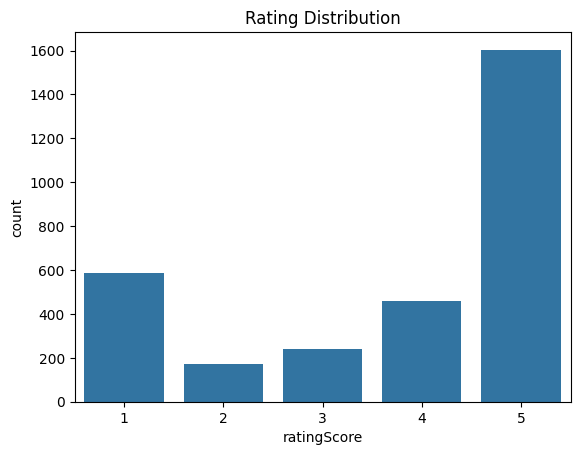

In [6]:
# Plot rating distribution
if 'ratingScore' in df.columns:
    sns.countplot(x='ratingScore', data=df)
    plt.title('Rating Distribution')
    plt.show()

## **Word Cloud**

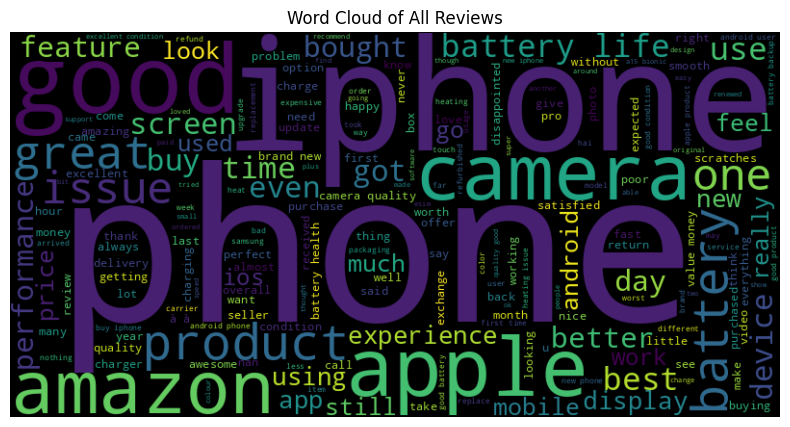

In [7]:
# Generate Word Cloud for all reviews
all_text = ' '.join(review for review in df['processed_review'])
wordcloud = WordCloud(width=800, height=400, random_state=42).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Reviews')
plt.show()

# **Sentiment Analysis**

## **Sentiment Distribution**

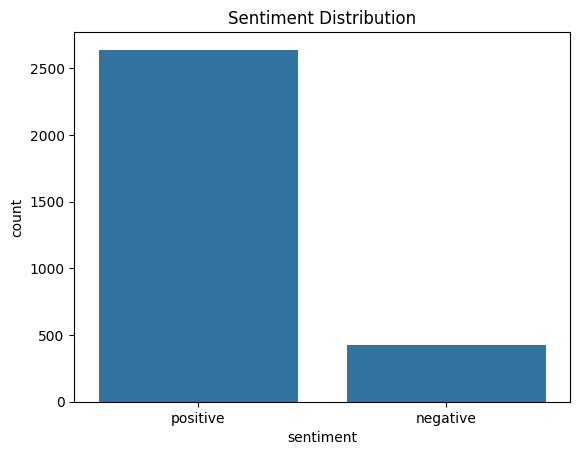

In [8]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment scoring
df['sentiment_score'] = df['processed_review'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0 else 'negative')

# Visualize sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

## **Classification Report**

In [9]:
# Machine Learning based sentiment analysis
# Create binary sentiment label
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment_label'], test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train logistic regression model
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

# Evaluate model
y_pred = lr.predict(X_test_tfidf)
print("Classification Report for Sentiment Analysis:")
print(classification_report(y_test, y_pred))

Classification Report for Sentiment Analysis:
              precision    recall  f1-score   support

           0       0.90      0.13      0.22        71
           1       0.90      1.00      0.94       542

    accuracy                           0.90       613
   macro avg       0.90      0.56      0.58       613
weighted avg       0.90      0.90      0.86       613



## **Confusion matrix**

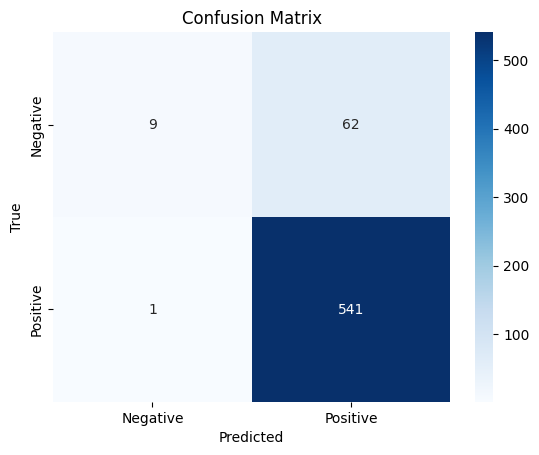

In [10]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Sentiment Word Frequency Analysis**

Top 10 words in positive reviews:
[('phone', 1363), ('iphone', 1068), ('good', 918), ('battery', 679), ('camera', 573), ('apple', 444), ('product', 421), ('like', 388), ('13', 375), ('new', 353)]

Top 10 words in negative reviews:
[('phone', 292), ('iphone', 142), ('battery', 124), ('apple', 95), ('product', 89), ('amazon', 87), ('buy', 67), ('camera', 66), ('service', 64), ('working', 60)]


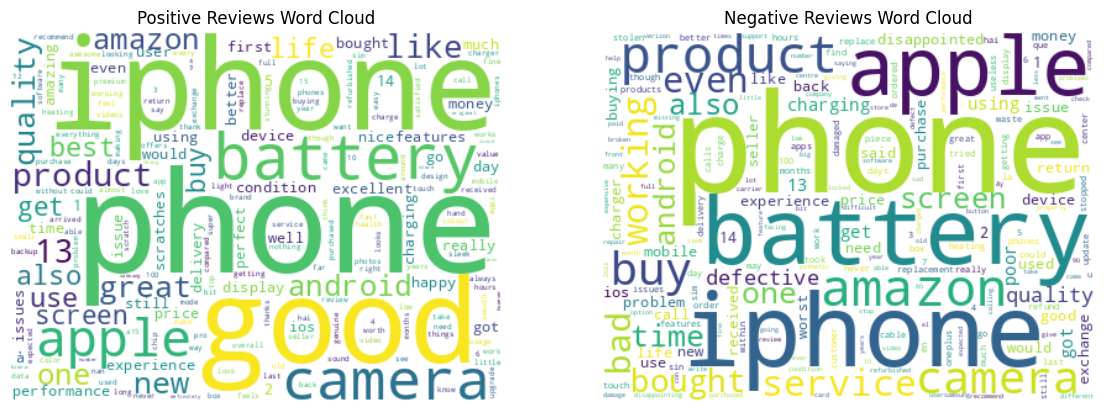

In [11]:
from collections import Counter
from wordcloud import WordCloud

# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['processed_review']
negative_reviews = df[df['sentiment'] == 'negative']['processed_review']

# Count words in positive reviews
positive_words = ' '.join(positive_reviews).split()
positive_word_counts = Counter(positive_words)

# Count words in negative reviews
negative_words = ' '.join(negative_reviews).split()
negative_word_counts = Counter(negative_words)

# Display top words for positive and negative sentiments
print("Top 10 words in positive reviews:")
print(positive_word_counts.most_common(10))

print("\nTop 10 words in negative reviews:")
print(negative_word_counts.most_common(10))

# Word Clouds for Positive and Negative Reviews
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
positive_wc = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(positive_word_counts)
negative_wc = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(negative_word_counts)

ax[0].imshow(positive_wc, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Positive Reviews Word Cloud')

ax[1].imshow(negative_wc, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Negative Reviews Word Cloud')

plt.show()

# **Named Entity Recognition (NER)**

In [12]:
import spacy

# Load SpaCy's English language model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Define a function to extract entities
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply the function and display a sample
df['entities'] = df['processed_review'].apply(extract_entities)
print("Sample entities extracted:")
print(df[['processed_review', 'entities']].head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Sample entities extracted:
                                    processed_review  \
0  every thing good iphones nothing compared spee...   
1  look fabulous android user switched apple perf...   
2  tried flip camera recording facility added pau...   
3                                        100 genuine   
4                   happy get iphone 13 amazon offer   

                            entities  
0  [(indian, NORP), (62k, CARDINAL)]  
1                                 []  
2                 [(first, ORDINAL)]  
3                  [(100, CARDINAL)]  
4                   [(13

# **Feature-Based Sentiment Analysis**

In [13]:
# Define feature keywords
features = ['battery', 'camera', 'screen', 'price', 'performance']

# Create a dictionary to store sentiments for each feature
feature_sentiment = {feature: [] for feature in features}

# Populate the dictionary with sentiment scores based on keyword mentions
for index, row in df.iterrows():
    for feature in features:
        if feature in row['processed_review']:
            feature_sentiment[feature].append(row['sentiment_score'])

# Average sentiment score for each feature
feature_sentiment_avg = {feature: (sum(scores) / len(scores)) if scores else 0 for feature, scores in feature_sentiment.items()}

# Display feature sentiment
print("Average sentiment score for each feature:")
for feature, score in feature_sentiment_avg.items():
    print(f"{feature}: {score:.2f}")

Average sentiment score for each feature:
battery: 0.54
camera: 0.65
screen: 0.55
price: 0.59
performance: 0.70


# **Visualization of Sentiment Trends Over Time**

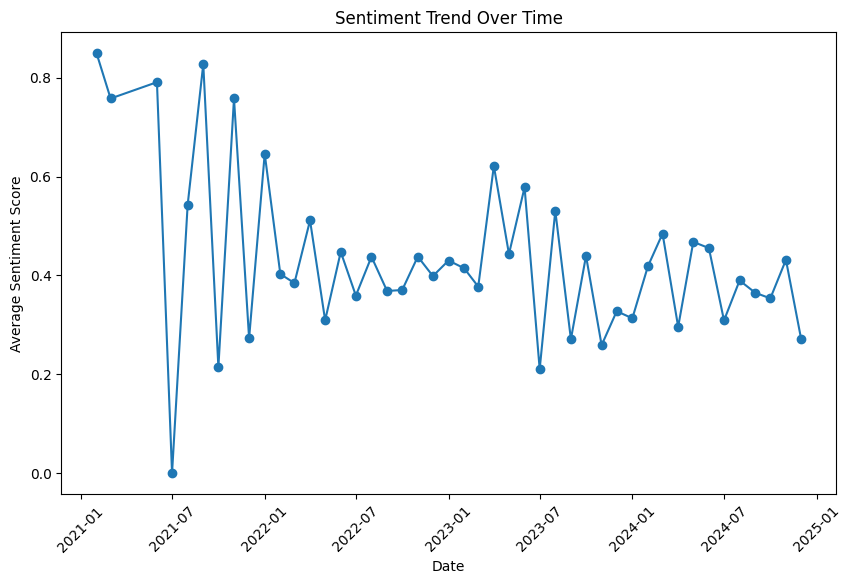

In [14]:
# Convert 'date' column to datetime if necessary
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group by date to get average sentiment score
sentiment_trend = df.groupby(df['date'].dt.to_period('M'))['sentiment_score'].mean().reset_index()
sentiment_trend['date'] = sentiment_trend['date'].dt.to_timestamp()

# Plot sentiment trend over time
plt.figure(figsize=(10, 6))
plt.plot(sentiment_trend['date'], sentiment_trend['sentiment_score'], marker='o')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Trend Over Time')
plt.xticks(rotation=45)
plt.show()

# **Feature Analysis**

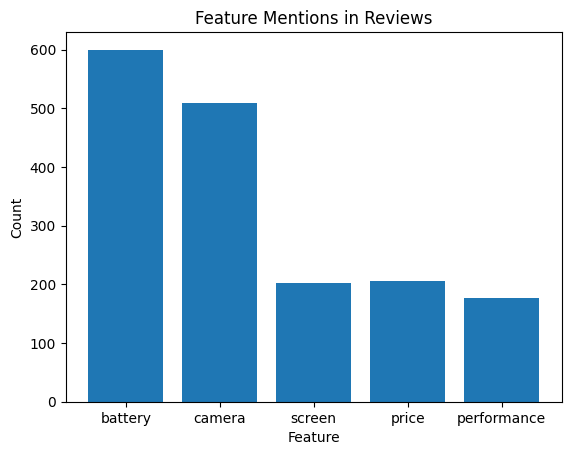

In [15]:
# Identify key features
features = ['battery', 'camera', 'screen', 'price', 'performance']

# Count occurrences of each feature
feature_counts = {feature: df['processed_review'].str.contains(feature).sum() for feature in features}

# Plot feature mentions
plt.bar(feature_counts.keys(), feature_counts.values())
plt.title('Feature Mentions in Reviews')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.show()

# **Topic Modeling**

In [16]:
# Vectorize text
tfidf = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = tfidf.fit_transform(df['processed_review'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
print("Topics in iPhone reviews:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topics in iPhone reviews:
Topic 1:
['performance', 'service', 'amazon', 'camera', 'product', '13', 'apple', 'phone', 'iphone', 'nice']
Topic 2:
['seller', 'received', 'defective', 'genuine', 'delivery', 'delivered', 'phone', 'amazon', 'product', 'good']
Topic 3:
['life', 'happy', 'awesome', 'new', 'great', 'like', 'battery', 'good', 'best', 'phone']
Topic 4:
['love', 'features', 'superb', 'product', 'phone', 'good', 'camera', 'excellent', 'quality', 'nan']
Topic 5:
['bought', 'condition', 'good', 'amazing', 'value', 'perfect', 'battery', 'money', 'iphone', 'phone']
